This is a pet project where I will be trying to build a chatbot using a transformer architecture based neural network. I'll be using the famous [Cornell Movie Dialog Dataset](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html) to train my model. Lets see how it goes

In [7]:
# Importing some pretty important dependencies
import tensorflow as tf
assert tf.__version__.startswith('2')

import tensorflow_datasets as tfds

import os
import re
import numpy as np
import pickle

import matplotlib.pyplot as plt
tf.random.set_seed(1234)


#### Download Data

In [12]:
# Need to download the dataset and save it offile for the first time
# Keras utils have very useful functions and get_file is one of them.
# Function brings the file and stores in cache(temp) directory.
zip_path = tf.keras.utils.get_file(fname='cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

# Follow thedirectory structure to the input files
dataset_path = os.path.join(
    os.path.dirname(zip_path), "cornell movie-dialogs corpus")
print(dataset_path)

C:\Users\ameys\.keras\datasets\cornell movie-dialogs corpus


In [21]:
movie_lines_path = os.path.join(dataset_path, 'movie_lines.txt')
movie_conversations_path = os.path.join(dataset_path, "movie_conversations.txt")
print(movie_lines_path, "\n"+movie_conversations_path)

C:\Users\ameys\.keras\datasets\cornell movie-dialogs corpus\movie_lines.txt 
C:\Users\ameys\.keras\datasets\cornell movie-dialogs corpus\movie_conversations.txt


#### Processing Data

**Below are the steps that I am going to follow to preprocess the data**

    -Process each input text and remove all the special characters except for .,!
    
    -Build a tokenizer 
    
    -Tokenize each input and also add a START and END token
    
    -Choose a MAX_LENGTH and pad/strip the inputs accordingly
    

In [76]:
MAX_SAMPLES = 100000
def process_text(text):
    text = text.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,])", r" \1 ", text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    text = re.sub(r"[^a-zA-Z0-9?.,!]+", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def load_data():
    id2line = {}
    with open(movie_lines_path, errors='ignore') as fp:
        for line in fp.readlines():
            parts = line.replace('\n', '').split(' +++$+++ ')
            id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(movie_conversations_path, 'r') as fp:
        for line in fp.readlines():
            parts = line.replace('\n', '').split(' +++$+++ ')
            # get conversation in a list of line ID
            conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
            for i in range(len(conversation) - 1):
                inputs.append(process_text(id2line[conversation[i]]))
                outputs.append(process_text(id2line[conversation[i + 1]]))
            if len(inputs) > MAX_SAMPLES:
                return inputs, outputs
            
questions, answers = load_data()

In [77]:
print('Sample question: {}'.format(questions[595]))
print('Sample answer: {}'.format(answers[595]))

Sample question: i should not even be listening to you , since my council said no . but santangel tells me you are a man of honor and sincerity . . . and sanchez , that you are not a fool .
Sample answer: no more than the woman who said she would take granada from the moors .


In [78]:
# Build a tokenizer with the vocabulary in both questions and answers
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions + answers, 
                                                                    target_vocab_size=2**13)

In [79]:
# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

MEAN:  [39.]


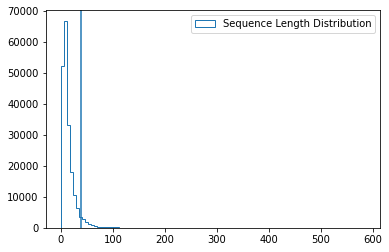

In [80]:
# Setting Maximum Sequence Length
input_lengths = [len(text.split()) for text in questions+answers]
plt.hist(input_lengths, bins = 100, histtype='step', label='Sequence Length Distribution')
plt.axvline(np.quantile(input_lengths, [0.95]))
plt.legend();
print("MEAN: ",np.quantile(input_lengths, [0.95]))

In [81]:
# If we set the sequence length to 40 words then we can consider 95% of data without stripping

In [82]:
# Maximum sentence length
MAX_LENGTH = 40


# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)
        
    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs,
                                                                     maxlen=MAX_LENGTH,
                                                                     truncating='post',
                                                                     padding='post',
                                                                    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs,
                                                                      maxlen=MAX_LENGTH,
                                                                      padding='post',
                                                                      truncating='post',
                                                                     )

    return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)

In [83]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 8212
Number of samples: 100003


#### Create a Tensorflow Dataset

In [89]:
BATCH_SIZE = 128
BUFFER_SIZE = 30000

# decoder inputs use the previous target as input
# removing the END_TOKEN from answers
# removing START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))


dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


#### Building a Scaled dot product Attention mechanism

In [90]:
"""
Scaled dot product attention mechanism has 3 inputs Query(Q), Key(K) and Value(V).

Among these 3 inputs firstly, Q and K^T undergo a dot product

the result of dot product is scaled by dividing with sqrt(dimensions)

the scaled result is them passed through a softmax function which yields the attension weights 
for each word with rest of the words in that input sequence.

At the end the attention weights undergo dot product with the V
"""
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output